In [1]:
%matplotlib inline

In [2]:
import numpy as np
from nighres import io, surface
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
import pickle
from nipype.interfaces import fsl
from glob import glob
import os

In [3]:
def jo2allen_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 1,2)
    data = np.flip(np.flip(data,1),0)
    return data

#### Make levelset from tight cortex mask 

Cortex mask derived from layer masks, see notebook "Allen_API"

In [ ]:
lvl=surface.probability_to_levelset("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz")
lvl['result'].to_filename("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [4]:
lvl = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [11]:
nb.save(nb.Nifti1Image(np.asarray(lvl.get_data(), dtype='float32'), np.eye(4)), 
        "/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

#### Downsample mask, annotation volume and levelset to 200 um

In [ ]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   apply_isoxfm=0.2,
                   interp="spline",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200um.nii.gz")
resamp.run()

In [5]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/annotation.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/annotation.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/annotation_200um.nii.gz")
resamp.cmdline

'flirt -in /home/julia/data/gradients/atlas/allen_api/annotation.nii.gz -ref /home/julia/data/gradients/atlas/allen_api/annotation.nii.gz -out /home/julia/data/gradients/atlas/allen_api/annotation_200um.nii.gz -omat annotation_flirt.mat -applyisoxfm 0.200000 -interp nearestneighbour'

In [35]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz")
resamp.run()

#### Bring original data in 200 um into allen space

In [32]:
# extract info from example image
img = nb.load("/home/julia/data/gradients/orig/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold.nii.gz")
data = img.get_data()
shape_allen = jo2allen_vol(data[:,:,:,0]).shape
num_vol = data.shape[3]

aff = np.eye(4)*0.2
aff[3,3]=1

hdr = nb.Nifti1Header()
hdr['dim']=np.array([4, shape_allen[0], shape_allen[1], shape_allen[2], num_vol, 
                     1, 1, 1], dtype='int16')
hdr['pixdim']=img.header['pixdim']


# load each image, transform and save
func = glob("/home/julia/data/gradients/orig/*MEDISO*EPI*.nii.gz")

for f in func:
    data_allen = np.zeros((shape_allen[0], shape_allen[1], shape_allen[2], num_vol))
    data_jo = nb.load(f).get_data()
    
    for vol in range(num_vol):
        data_allen[:,:,:,vol] = jo2allen_vol(data_jo[:,:,:,vol])

    nb.save(nb.Nifti1Image(data_allen, aff, hdr),
            "/home/julia/data/gradients/orig_allen/%s_allen.nii.gz" % os.path.basename(f).split(".")[0])

#### Plot mesh and mask on data for qa

In [5]:
mesh = io.load_mesh_geometry("/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk")
img = nb.load("/home/julia/data/gradients/orig_allen/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold.nii.gz")
data = img.get_data()
mask = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz").get_data()
mask[mask==0]=np.nan

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


(-0.5, 56.5, 39.5, -0.5)

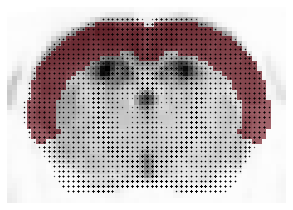

In [6]:
x = 30
fig = plt.figure(figsize=(5,5))
mesh_slice = np.floor(mesh['points'][(mesh['points'][:,0]-x*200)<1][:,1:]/200)
plt.scatter(mesh_slice[:,1], mesh_slice[:,0], s=0.1, color='black');
plt.imshow(data[x, :, :,0], cmap='Greys');
plt.imshow(mask[x, :, :], cmap='Reds_r', alpha=0.6);
plt.axis('off')

Because of imperfect alignment the upper voxels seem to not be sampled exactly, we can fix that by using the first datapoints when sampling, even at places where the mask is 0